## Modeling the New York Times Covid-19 Data

Implement a simple Bayesian hierarchical model to forecast new cases (and deaths?) over the next few days.


In [1]:
import numpy as np
import pandas as pd
import json
import herepy
import plotly.graph_objects as go
import datetime
import dateutil.parser

geocoderApi = herepy.GeocoderApi('VbY-MyI6ZT9U8h-Y5GP5W1YaOzQuvNnL4aSTulNEyEQ')
df_counties = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv", dtype={"fips": str})
df_states = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", dtype={"fips": str})
df_census = pd.read_csv('data/county_2019_census.csv')
df_geo = pd.read_csv("https://raw.githubusercontent.com/jdlafferty/covid-19/master/geo-counties.csv", dtype={"fips": str})


In [2]:

def compute_lat_lon(df, geocoder):
    county = list(df['county'])
    state = list(df['state'])
    fips = list(df['fips'])
    cases = list(df['cases'])
    deaths = list(df['deaths'])
    lat = list(np.zeros(len(county)))
    lon = list(np.zeros(len(county)))

    num_to_print=20
    for i in range(len(county)):
        if type(fips[i])==str:
            response = geocoder.free_form('%s, %s' % (county[i], state[i]))
            result = response.as_json_string()
            res = eval(result)
            (clat, clon) = (res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],
                      res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude'])
            lat[i] = clat
            lon[i] = clon
            if (i <= num_to_print) | (i % int(len(county)/20) == 0):
                print("%s, %s: cases=%d, deaths=%d, lat=%f, lon=%f" % \
                        (county[i], state[i], cases[i], deaths[i], lat[i], lon[i]))
                if (i>=num_to_print):
                    print("...")            
    return (lat,lon)


def lat_lon_of_address(addr):
    response = geocoderApi.free_form(addr)
    type(response)
    result = response.as_json_string()
    res = eval(result)
    (lat, lon) = (res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],
                  res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude'])
    return (lat, lon)


def county_state_of_address(addr):
    response = geocoderApi.free_form(addr)
    type(response)
    result = response.as_json_string()
    res = eval(result)
    state = res['Response']['View'][0]['Result'][0]['Location']['Address']['AdditionalData'][1]['value']
    county = res['Response']['View'][0]['Result'][0]['Location']['Address']['AdditionalData'][2]['value']
    return (county, state)


In [3]:
def process_recent_data(days_back=7):
    date = [dateutil.parser.parse(d) for d in np.array(df_counties['date'])]
    last_date = max(date)
    most_recent_date = last_date.strftime("%Y-%m-%d")
    most_recent_date_long = last_date.strftime("%A %B %-d, %Y")
    print("Most recent data: %s" % most_recent_date_long)    

    days = np.array([(last_date - d).days for d in date])
    df_recent = df_counties[days < days_back]
    df_recent = df_recent.sort_values('cases', ascending=False)
    df_recent = df_recent.reset_index().drop('index',1)
    
    df_recent = pd.merge(df_recent, df_geo)
    df_recent = pd.merge(df_recent, df_census, how='left', on=['county','state'])
    df_recent = df_recent[df_recent['county'] != 'Unknown']
    df_recent['population'] = np.array(df_recent['population'], dtype='int')
    
    cases = np.array(df_recent['cases'])
    population = np.array(df_recent['population'])
    cases_per_100k = np.round(100000*np.array(cases/population),1)
    df_recent['cases_per_100k'] = cases_per_100k
    
    return (df_recent, most_recent_date_long)


In [4]:
df_recent, most_recent_date = process_recent_data(days_back=7)
df_recent.head(30)

Most recent data: Saturday April 4, 2020


,date,county,state,fips,cases,deaths,lat,lon,population,cases_per_100k
0,2020-04-04,New York City,New York,NaN,63307,2254,40.71455,-74.00714,8900000,711.3
1,2020-04-03,New York City,New York,NaN,57160,1867,40.71455,-74.00714,8900000,642.2
2,2020-04-02,New York City,New York,NaN,51810,1562,40.71455,-74.00714,8900000,582.1
3,2020-04-01,New York City,New York,NaN,47440,1374,40.71455,-74.00714,8900000,533.0
4,2020-03-31,New York City,New York,NaN,43139,1096,40.71455,-74.00714,8900000,484.7
5,2020-03-30,New York City,New York,NaN,38087,914,40.71455,-74.00714,8900000,427.9
6,2020-03-29,New York City,New York,NaN,33768,776,40.71455,-74.00714,8900000,379.4
7,2020-04-04,Nassau,New York,36059,13346,396,42.51642,-73.61127,1356924,983.5
8,2020-04-03,Nassau,New York,36059,12024,138,42.51642,-73.61127,1356924,886.1
9,2020-04-02,Nassau,New York,36059,10587,95,42.51642,-73.61127,1356924,780.2


In [5]:
def compute_deltas(df, days_back=30):
    nd = pd.DataFrame()
    counties = list(df['county'])
    states = list(df['state'])
    state_county = set([sc for sc in zip(states, counties)])
    for (state, county) in state_county:
        this_county = pd.DataFrame(df[(df['county']==county) & (df['state']==state)])
        cp100k = np.array(this_county['cases_per_100k'])
        delta = np.append(np.maximum(-np.diff(cp100k),0), np.nan)
        this_county['delta'] = delta
        nd = nd.append(this_county)

    date = [dateutil.parser.parse(d) for d in np.array(nd['date'])]
    last_date = max(date)
    days = np.array([(last_date - d).days for d in date])
    nd = nd[days < days_back]
    nd = nd.sort_values(['cases', 'state', 'county'], ascending = (False, True, True))
    return nd


In [6]:
df_delta = compute_deltas(df_recent, days_back=3)

In [7]:
df_delta.head(50)

,date,county,state,fips,cases,deaths,lat,lon,population,cases_per_100k,delta
0,2020-04-04,New York City,New York,NaN,63307,2254,40.71455,-74.00714,8900000,711.3,69.1
1,2020-04-03,New York City,New York,NaN,57160,1867,40.71455,-74.00714,8900000,642.2,60.1
2,2020-04-02,New York City,New York,NaN,51810,1562,40.71455,-74.00714,8900000,582.1,49.1
7,2020-04-04,Nassau,New York,36059,13346,396,42.51642,-73.61127,1356924,983.5,97.4
14,2020-04-04,Westchester,New York,36119,13080,197,41.11909,-73.78870,967506,1351.9,75.4
15,2020-04-03,Westchester,New York,36119,12350,67,41.11909,-73.78870,967506,1276.5,81.1
21,2020-04-04,Suffolk,New York,36103,12328,175,40.96009,-72.83434,1476601,834.9,147.2
8,2020-04-03,Nassau,New York,36059,12024,138,42.51642,-73.61127,1356924,886.1,105.9
16,2020-04-02,Westchester,New York,36119,11566,67,41.11909,-73.78870,967506,1195.4,91.2
9,2020-04-02,Nassau,New York,36059,10587,95,42.51642,-73.61127,1356924,780.2,76.0


In [8]:
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline


In [9]:
def initialize_for_simulation(df_delta):
    df = df_delta.drop(['lat','lon', 'fips'], axis=1)
    df_nonzero = df[df['delta'] > 0]
    df = pd.DataFrame(df_nonzero)
    df['z'] = np.log(np.array(df['delta'])/1e5) - np.log(1-np.array(df['delta'])/1e5)
    df['psi'] = df['z']
    df['var'] = 1/(np.array(df['delta'])*(1-np.array(df['delta']/1e5)))
    df['d'] = 1/(1+1/np.array(df['var']))
    df = df.reset_index().drop('index',1)
    return df

Text(0.5, 1.0, 'd')

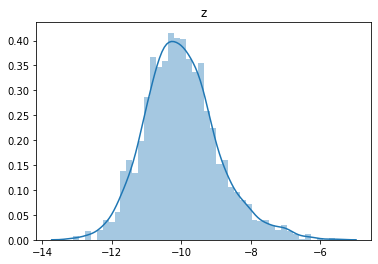

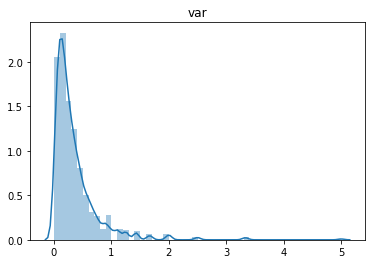

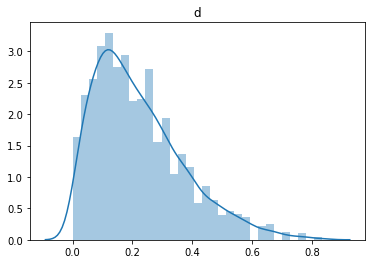

In [10]:
df = initialize_for_simulation(df_delta)
plt.figure()
sbn.distplot(np.array(df['z'])).set_title('z')
plt.figure()
sbn.distplot(np.array(df['var'])).set_title('var')
plt.figure()
sbn.distplot(np.array(df['d'])).set_title('d')


In [11]:
def run_gibbs_sampler(df, B=10000, burn=1000):
    k = df.shape[0]
    v = np.sqrt(1/k)
    n = df.shape[0]
    psi = np.matrix(np.zeros(n*B)).reshape((B,n))
    psi[0,:] = df['psi']
    scale = np.sqrt(df['d'])
    for b in np.arange(B-1):
        loc = np.mean(psi[b,:])
        mu = np.random.normal(loc=loc, scale=v)
        e = df['d']*(mu + df['z']/df['var'])
        psi[b+1,:] = np.random.normal(loc=e, scale=scale)
    return psi[np.arange(burn,B),:]

def make_predictions(df, psi):
    # compute posterior and mean and credible interval
    psi_95 = np.percentile(psi, 95, axis=0)
    psi_bar = np.array(np.mean(psi, axis=0))[0]
    delta_bar = 1e5*np.exp(psi_bar)/(1+np.exp(psi_bar))
    delta_95 = 1e5*np.exp(psi_95)/(1+np.exp(psi_95))
    df['delta_bar'] = np.round(delta_bar, 2)
    df['delta_95'] = np.round(delta_95, 2)
    df = df.drop(['z','psi','d','var'], axis=1)
    
    date = [dateutil.parser.parse(d) for d in np.array(df['date'])]
    most_recent_date = max(date).strftime("%Y-%m-%d")
    df = df[df['date'] == most_recent_date]

    # make Bayes predictions for the most recent date
    cases_predicted = (df['population']/100000)*(df['cases_per_100k']+df['delta_bar'])
    cases_predicted = cases_predicted.astype(int)
    df['cases_predicted'] = cases_predicted
    cases_95_credible = (df['population']/100000)*(df['cases_per_100k']+df['delta_95'])
    cases_95_credible = cases_95_credible.astype(int)
    df['cases_95_credible'] = cases_95_credible
    
    return df

In [12]:
df = initialize_for_simulation(df_delta)
psi = run_gibbs_sampler(df)
df = make_predictions(df, psi)
df


,date,county,state,cases,deaths,population,cases_per_100k,delta,delta_bar,delta_95,cases_predicted,cases_95_credible
0,2020-04-04,New York City,New York,63307,2254,8900000,711.3,69.1,66.64,81.11,69236,70524
3,2020-04-04,Nassau,New York,13346,396,1356924,983.5,97.4,94.66,111.29,14629,14855
4,2020-04-04,Westchester,New York,13080,197,967506,1351.9,75.4,72.89,87.89,13784,13930
6,2020-04-04,Suffolk,New York,12328,175,1476601,834.9,147.2,144.02,164.84,14454,14762
12,2020-04-04,Cook,Illinois,7439,167,5150233,144.4,18.7,17.56,25.29,8341,8739
...,...,...,...,...,...,...,...,...,...,...,...,...
3301,2020-04-04,Charles Mix,South Dakota,2,0,9292,21.5,10.7,10.12,16.43,2,3
3303,2020-04-04,Blanco,Texas,2,0,11931,16.8,8.4,7.98,13.68,2,3
3307,2020-04-04,Lavaca,Texas,2,0,20154,9.9,4.9,4.94,9.69,2,3
3309,2020-04-04,Greene,Virginia,2,0,19819,10.1,5.1,5.17,9.92,3,3


In [13]:
df[df['state']=='Connecticut']


,date,county,state,cases,deaths,population,cases_per_100k,delta,delta_bar,delta_95,cases_predicted,cases_95_credible
41,2020-04-04,Fairfield,Connecticut,2824,86,943332,299.4,11.4,10.81,17.45,2926,2988
110,2020-04-04,New Haven,Connecticut,1024,29,854757,119.8,15.6,14.70,22.00,1149,1212
151,2020-04-04,Hartford,Connecticut,726,26,891720,81.4,5.3,5.35,10.44,773,818
495,2020-04-04,Litchfield,Connecticut,182,5,180333,100.9,5.0,5.08,10.07,191,200
755,2020-04-04,Middlesex,Connecticut,100,4,162436,61.6,5.6,5.56,10.59,109,117
794,2020-04-04,Tolland,Connecticut,91,10,150721,60.4,8.0,7.71,13.46,102,111
1068,2020-04-04,New London,Connecticut,57,3,265206,21.5,6.4,6.26,11.56,73,87
1507,2020-04-04,Windham,Connecticut,31,1,116782,26.5,3.4,3.80,8.28,35,40
